In [1]:
import os, numpy as np, agama, scipy.special, scipy.integrate, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import Latex
agama.setUnits(length=1, velocity=1, mass=1) #kpc,km/s, Solar mass

In [2]:
pot_sun_ideal = agama.Potential(dict(type='Plummer', mass =1, scaleRadius=1e-14))

In [3]:
np.isclose(pot_sun_ideal.potential([0.0,0.0,1.0]),-agama.G)

np.True_

In [4]:
##Minicluster

In [5]:
# Minicluster parameters
mc_mass0=1e-7
mc_rvir=1e-4
mc_rs=1e-5
Nbody=10000

In [6]:
pot_mc_nfw  = agama.Potential(type='spheroid', gamma=1, beta=3, scaleradius=mc_rs, outercutoffradius=mc_rvir, mass=mc_mass0)
df_mc = agama.DistributionFunction(type='quasispherical', potential=pot_mc_nfw)
mc_mass0 = pot_mc_nfw.totalMass()
print('Minicluster mass in M_sun',mc_mass0)

Minicluster mass in M_sun 9.999999999999996e-08


In [7]:
mcp_xv, mcp_mass = agama.GalaxyModel(pot_mc_nfw, df_mc).sample(Nbody)

In [8]:
def kinetic_permass(velocities,mass):
    return 0.5*np.sum(velocities**2, axis=1)


In [9]:
mcp_pot0=agama.Potential(type='multipole', particles=(mcp_xv[:,0:3] , mcp_mass), symmetry='n', lmax=50)

In [10]:
T_p=kinetic_permass(mcp_xv[:,3:6],mcp_mass)
U_p=mcp_pot0.potential(mcp_xv[:,:3])
T=np.sum(T_p)
U=np.sum(U_p)
print('Testing virial theorem, (3U/5)/(2T)=',-(3*U)/(10*T))

Testing virial theorem, (3U/5)/(2T)= 1.2074576451806196


In [12]:
#DELETE pot_total=agama.Potential(agama.Potential(potential=mcp_pot,center=[0,0,0]),agama.Potential(potential=pot_sun_ideal,center=[8,0,0]))

In [13]:
bound=T_p+U_p<0

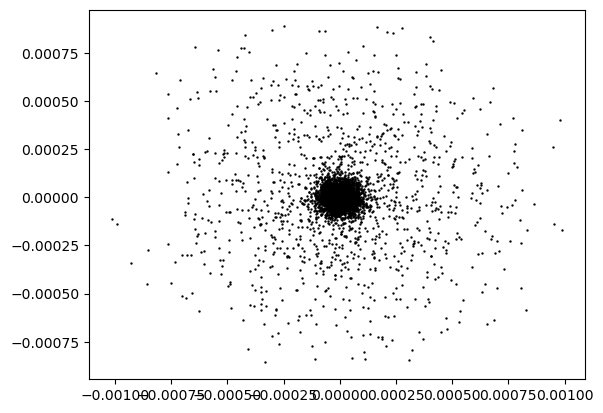

In [14]:
plt.scatter(mcp_xv[:,0][bound],mcp_xv[:,2][bound],color='k',s=0.5)

In [15]:
tupd=1e-2
time_start=0
times_t  = [time_start]
times_u  = [time_start]
mc_mass=[mc_mass0]

In [16]:
mc_center=[8,0,-0.1,0,0,220]
mcp_xv+=mc_center
mc_traj=[mc_center]
mc_time=[time_start]

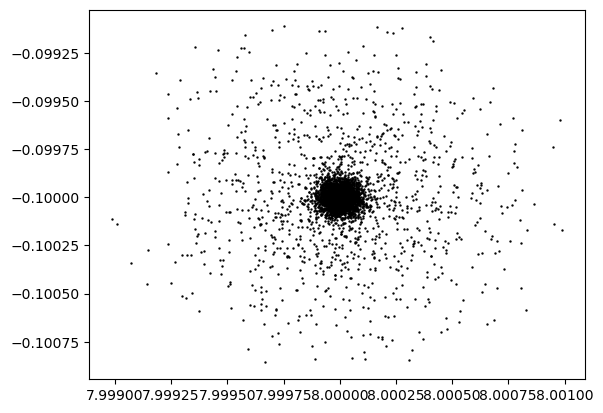

In [17]:
plt.scatter(mcp_xv[:,0],mcp_xv[:,2],s=0.5,c='k')


In [18]:
def orbitDF(ic, time, timestart, trajsize, mass,potential):
    if mass == 0:
        return agama.orbit(ic=ic, potential=potential, time=time, timestart=timestart, trajsize=trajsize,accuracy=1e-10)
    times = np.linspace(timestart, timestart+time, trajsize)
    sol=solve_ivp(
        lambda t, xv: np.hstack((xv[3:6], 
                                potential.force(xv[0:3], t=t) )),
        [timestart, timestart+time],
        ic,
        method='DOP853',
        t_eval=times,
        rtol=1e-12,
        atol=1e-14
    )
    return sol.t, sol.y.T


In [26]:
simulation_time=0.2
time_i=time_start
while time_i<simulation_time:
    mc_time_center,mc_orbit_center=orbitDF(ic=mc_center,time=tupd,timestart=time_i,trajsize=100,mass=0,potential=agama.Potential(potential=pot_sun_ideal,center=[8,0,0]) )
    print(time_i,mc_time_center,mc_orbit_center)
    
    mc_center=mc_orbit_center[-1]
    mc_time.extend(mc_time_center)
    mc_traj.extend(mc_orbit_center)

    pot_total=agama.Potential(agama.Potential(potential=pot_sun_ideal,center=[8,0,0]),
                              agama.Potential(potential=mcp_pot,center=np.column_stack((mc_time_center,mc_orbit_center))))
    mcp_pot=agama.Potential(type='multipole', particles=(mcp_xv[:,0:3] , mcp_mass), symmetry='n', lmax=50)

    time_i+=tupd


mc_traj=np.vstack(mc_traj)
mc_time=np.vstack(mc_time)

0 [0.         0.00010101 0.00020202 0.00030303 0.00040404 0.00050505
 0.00060606 0.00070707 0.00080808 0.00090909 0.0010101  0.00111111
 0.00121212 0.00131313 0.00141414 0.00151515 0.00161616 0.00171717
 0.00181818 0.00191919 0.0020202  0.00212121 0.00222222 0.00232323
 0.00242424 0.00252525 0.00262626 0.00272727 0.00282828 0.00292929
 0.0030303  0.00313131 0.00323232 0.00333333 0.00343434 0.00353535
 0.00363636 0.00373737 0.00383838 0.00393939 0.0040404  0.00414141
 0.00424242 0.00434343 0.00444444 0.00454545 0.00464646 0.00474747
 0.00484848 0.00494949 0.00505051 0.00515152 0.00525253 0.00535354
 0.00545455 0.00555556 0.00565657 0.00575758 0.00585859 0.0059596
 0.00606061 0.00616162 0.00626263 0.00636364 0.00646465 0.00656566
 0.00666667 0.00676768 0.00686869 0.0069697  0.00707071 0.00717172
 0.00727273 0.00737374 0.00747475 0.00757576 0.00767677 0.00777778
 0.00787879 0.0079798  0.00808081 0.00818182 0.00828283 0.00838384
 0.00848485 0.00858586 0.00868687 0.00878788 0.00888889 0.008

AttributeError: 'numpy.ndarray' object has no attribute 'extend'

array([[1.90000000e-01, 8.00000000e+00, 0.00000000e+00, 4.17000084e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90101010e-01, 8.00000000e+00, 0.00000000e+00, 4.17222290e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90202020e-01, 8.00000000e+00, 0.00000000e+00, 4.17444534e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90303030e-01, 8.00000000e+00, 0.00000000e+00, 4.17666740e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90404040e-01, 8.00000000e+00, 0.00000000e+00, 4.17888985e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90505051e-01, 8.00000000e+00, 0.00000000e+00, 4.18111191e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90606061e-01, 8.00000000e+00, 0.00000000e+00, 4.18333435e+01,
        0.00000000e+00, 0.00000000e+00, 2.20000000e+02],
       [1.90707071e-01, 8.00000000e+00, 0.00000000e+00, 4.18555641e+01,
        0.00000000e+00, 0

In [31]:
mcp_pot.potential([8,0,1],t=0.1)

-8.779588399973071e-14